In [1]:
import pandas as p
import numpy as np
import ast
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif

In [2]:
df= p.read_excel('in_chemico_dataset_processed.xlsx')
# df.describe()
df= df.dropna(axis=1,how='all')
df=df.drop(['Unnamed: 8', 'Unnamed: 9', 'Unnamed: 11','MoleculeStatus','Note'],axis=1)
constant_cols = df.columns[df.nunique() == 1]
df = df.drop(columns=constant_cols.to_list())
df=df.dropna()
df = df.drop(columns=['Name','IUPAC name','CAS registry number','Structure','SMILES code','Sources'])
df.shape




(161, 194)

In [3]:
def decode_fp_column(fp_series, n_bits=2048):
    matrix = np.zeros((len(fp_series), n_bits), dtype=int)
    for i, val in enumerate(fp_series):
        try:
            indices = ast.literal_eval(val)
            matrix[i, indices] = 1
        except:
            pass
    return matrix

morgan_bits = decode_fp_column(df['Morgan2048'])
rdkit_bits = decode_fp_column(df['RDkit2048'])
df = df.drop(columns=['Morgan2048','RDkit2048'])



In [4]:
y =df['Phototoxicity']
x =df.drop(columns='Phototoxicity')

print("Features shape:", x.shape)
print("Target shape:", y.shape)
# rdkit_bits
x = np.hstack([x, morgan_bits, rdkit_bits])
# rdkit_bits
print("Final shape:", x.shape)

Features shape: (161, 191)
Target shape: (161,)
Final shape: (161, 4287)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [6]:
scaler = StandardScaler()
X_train[:, :191] = scaler.fit_transform(X_train[:, :191])
X_test[:, :191] = scaler.transform(X_test[:, :191])
X_train_scaled = X_train
X_test_scaled = X_test

In [7]:
model = LogisticRegression(max_iter=2000, solver='lbfgs')
model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=2000)

In [8]:
y_pred = model.predict(X_test_scaled)

In [9]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.6060606060606061

Classification report:
               precision    recall  f1-score   support

           0       0.60      0.40      0.48        15
           1       0.61      0.78      0.68        18

    accuracy                           0.61        33
   macro avg       0.60      0.59      0.58        33
weighted avg       0.60      0.61      0.59        33


Confusion matrix:
 [[ 6  9]
 [ 4 14]]


In [10]:
import warnings
warnings.filterwarnings("ignore")
step =50
feature_counts = range(2, x.shape[1] + 1, step)
accuracies = []

for k in feature_counts:
    selector = SelectKBest(score_func=f_classif, k=min(k, x.shape[1]))
    X_train_k = selector.fit_transform(X_train_scaled, y_train)
    X_test_k = selector.transform(X_test_scaled)

    model = LogisticRegression(max_iter=2000, solver='lbfgs')
    model.fit(X_train_k, y_train)
    y_pred = model.predict(X_test_k)

    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"k = {k:4d} | accuracy = {acc:.3f}")
best_k = feature_counts[np.argmax(accuracies)]
best_acc = max(accuracies)

k =    2 | accuracy = 0.606
k =   52 | accuracy = 0.758
k =  102 | accuracy = 0.727
k =  152 | accuracy = 0.697
k =  202 | accuracy = 0.697
k =  252 | accuracy = 0.697
k =  302 | accuracy = 0.667
k =  352 | accuracy = 0.667
k =  402 | accuracy = 0.667
k =  452 | accuracy = 0.636
k =  502 | accuracy = 0.667
k =  552 | accuracy = 0.636
k =  602 | accuracy = 0.606
k =  652 | accuracy = 0.606
k =  702 | accuracy = 0.636
k =  752 | accuracy = 0.636
k =  802 | accuracy = 0.636
k =  852 | accuracy = 0.636
k =  902 | accuracy = 0.606
k =  952 | accuracy = 0.636
k = 1002 | accuracy = 0.636
k = 1052 | accuracy = 0.606
k = 1102 | accuracy = 0.606
k = 1152 | accuracy = 0.576
k = 1202 | accuracy = 0.606
k = 1252 | accuracy = 0.576
k = 1302 | accuracy = 0.576
k = 1352 | accuracy = 0.576
k = 1402 | accuracy = 0.576
k = 1452 | accuracy = 0.576
k = 1502 | accuracy = 0.576
k = 1552 | accuracy = 0.606
k = 1602 | accuracy = 0.606
k = 1652 | accuracy = 0.636
k = 1702 | accuracy = 0.636
k = 1752 | accuracy 

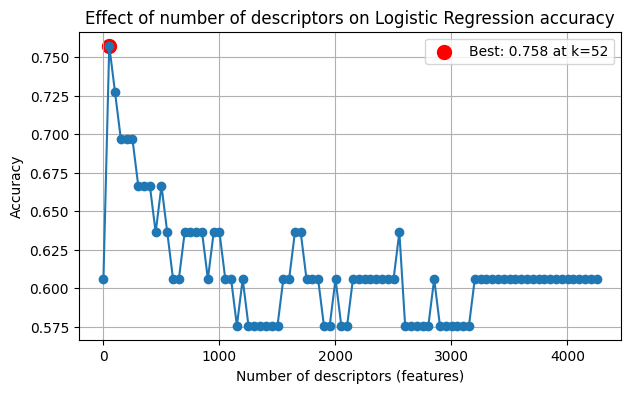

Best accuracy = 0.758 at k = 52


In [11]:
plt.figure(figsize=(7,4))
plt.plot(feature_counts, accuracies, marker='o')
plt.xlabel('Number of descriptors (features)')
plt.ylabel('Accuracy')
plt.title('Effect of number of descriptors on Logistic Regression accuracy')
plt.grid(True)

plt.scatter(best_k, best_acc, color='red', s=100, label=f'Best: {best_acc:.3f} at k={best_k}')
plt.legend()
plt.show()

print(f"Best accuracy = {best_acc:.3f} at k = {best_k}")


In [12]:
import warnings
warnings.filterwarnings("ignore")
step =70
feature_counts = range(2, x.shape[1] + 1, step)
accuracies = []

for k in feature_counts:
    X_train_k = X_train_scaled[:, :k]
    X_test_k = X_test_scaled[:, :k]

    model = LogisticRegression(max_iter=2000, solver='lbfgs')
    model.fit(X_train_k, y_train)
    y_pred = model.predict(X_test_k)

    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"k = {k:4d} | accuracy = {acc:.3f}")
best_k = feature_counts[np.argmax(accuracies)]
best_acc = max(accuracies)

k =    2 | accuracy = 0.667
k =   72 | accuracy = 0.515
k =  142 | accuracy = 0.545
k =  212 | accuracy = 0.606
k =  282 | accuracy = 0.606
k =  352 | accuracy = 0.606
k =  422 | accuracy = 0.636
k =  492 | accuracy = 0.636
k =  562 | accuracy = 0.636
k =  632 | accuracy = 0.636
k =  702 | accuracy = 0.636
k =  772 | accuracy = 0.636
k =  842 | accuracy = 0.636
k =  912 | accuracy = 0.636
k =  982 | accuracy = 0.636
k = 1052 | accuracy = 0.636
k = 1122 | accuracy = 0.636
k = 1192 | accuracy = 0.636
k = 1262 | accuracy = 0.606
k = 1332 | accuracy = 0.636
k = 1402 | accuracy = 0.636
k = 1472 | accuracy = 0.636
k = 1542 | accuracy = 0.636
k = 1612 | accuracy = 0.636
k = 1682 | accuracy = 0.636
k = 1752 | accuracy = 0.636
k = 1822 | accuracy = 0.636
k = 1892 | accuracy = 0.636
k = 1962 | accuracy = 0.606
k = 2032 | accuracy = 0.606
k = 2102 | accuracy = 0.636
k = 2172 | accuracy = 0.667
k = 2242 | accuracy = 0.636
k = 2312 | accuracy = 0.576
k = 2382 | accuracy = 0.576
k = 2452 | accuracy 

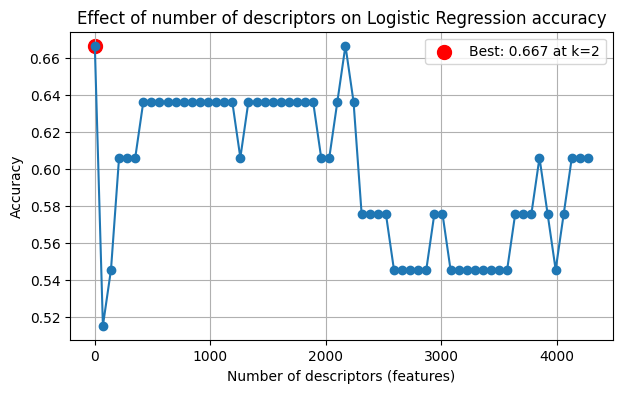

Best accuracy = 0.667 at k = 2


In [13]:
plt.figure(figsize=(7,4))
plt.plot(feature_counts, accuracies, marker='o')
plt.xlabel('Number of descriptors (features)')
plt.ylabel('Accuracy')
plt.title('Effect of number of descriptors on Logistic Regression accuracy')
plt.grid(True)

plt.scatter(best_k, best_acc, color='red', s=100, label=f'Best: {best_acc:.3f} at k={best_k}')
plt.legend()
plt.show()

print(f"Best accuracy = {best_acc:.3f} at k = {best_k}")